In [2]:
!python --version

Python 3.10.14


In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0


In [4]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray
import xarray as xr
from xmovie import Movie
import matplotlib.pyplot as plt
import warnings
from shapely.errors import ShapelyDeprecationWarning
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

warnings.filterwarnings(
    action='ignore',
    category=ShapelyDeprecationWarning,  # in cartopy
)
warnings.filterwarnings(
    action="ignore",
    category=UserWarning,
    message=r"No `(vmin|vmax)` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `\1` to avoid this step"
)

gcs = gcsfs.GCSFileSystem(token='anon')

print(jax.devices())
%matplotlib inline

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]


In [5]:
model_name = 'v1/deterministic_2_8_deg.pkl' 

with gcs.open(f'gs://neuralgcm/models/{model_name}', 'rb') as f:
  ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

In [6]:
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)

demo_start_time = '2020-02-14'
demo_end_time = '2020-02-15'
data_inner_steps = 24  # process every 24th hour

sliced_era5 = (
    full_era5
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
    .compute()
)

In [7]:
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)

regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

In [151]:
timedelta = np.timedelta64(1, 'h') #save every hour
ntimedelta = 1
nhours = 24 
ndays = 30
outer_steps = nhours * ndays * ntimedelta // ntimedelta #number of times to save each timedelta
times = (np.arange(outer_steps) * ntimedelta)  # time axis in hours

# initialize model state
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
# rng_key = jax.random.key(42)  # optional for deterministic models
# initial_state = model.encode(inputs, input_forcings, rng_key)
initial_state = model.encode(inputs, input_forcings)

# use persistence for forcing variables (SST and sea ice cover)
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

In [152]:
# make forecast
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)

2024-12-26 15:39:15.166963: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 5.78GiB (6203395610 bytes) by rematerialization; only reduced to 11.57GiB (12420094379 bytes), down from 11.57GiB (12426369771 bytes) originally


In [153]:
import pandas as pd
t0 = eval_era5.time[0].values
dts = np.array([int(t) * timedelta for t in times])
t = t0 + dts

In [154]:
predictions_ds = model.data_to_xarray(predictions, times=t)
predictions_ds = predictions_ds.resample(time='D').mean()
# predictions_ds["time"] = t.values

In [155]:
surface_ds = predictions_ds.sel(level = 1000, method = "nearest")
surface_era5_ds = eval_era5.sel(level = 1000, method = "nearest")

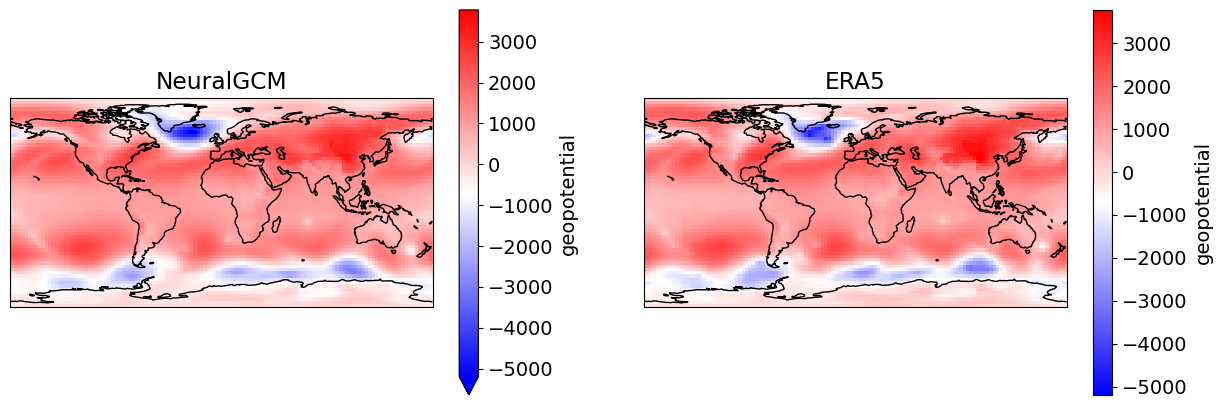

In [156]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

vmin, vmax = surface_era5_ds.geopotential.min(), surface_era5_ds.geopotential.max()
surface_ds.geopotential.T.isel(time = 1).plot(ax = ax[0], vmax = vmax, vmin = vmin,
                                        cmap = "bwr", transform = ccrs.PlateCarree())
ax[0].set_title("NeuralGCM")
surface_era5_ds.geopotential.T.isel(time = 1).plot(ax = ax[1], vmax = vmax, vmin = vmin,
                                             cmap = "bwr", transform = ccrs.PlateCarree())
ax[1].set_title("ERA5")
[a.coastlines() for a in ax]

In [157]:
KtoC = lambda x: x - 273.15
surface_temperature = 1 * surface_ds.temperature.T
surface_temperature = KtoC(surface_temperature)

surface_temperature_era5 = surface_era5_ds.temperature.T
surface_temperature_era5 = KtoC(surface_temperature_era5)

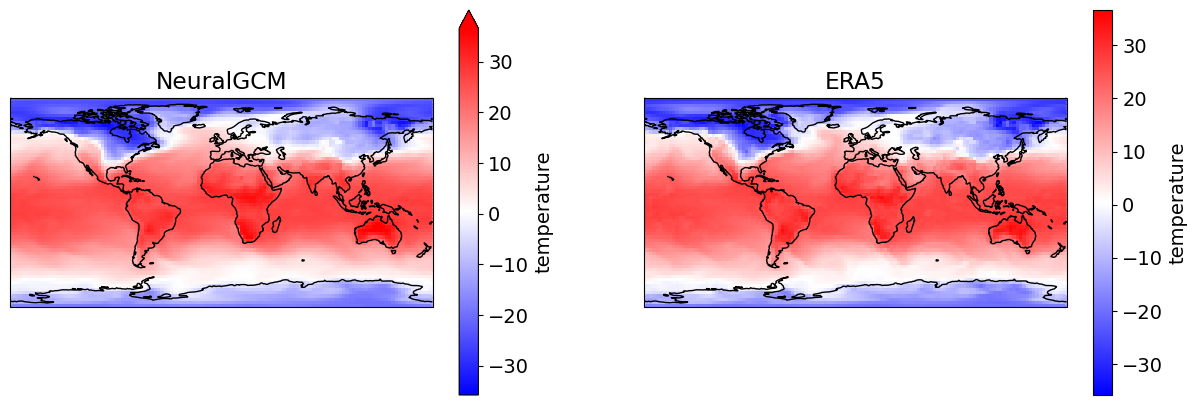

In [158]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})
vmin, vmax = surface_temperature_era5.min(), surface_temperature_era5.max()

surface_temperature.isel(time = 0).plot(ax = ax[0], 
                                        vmin = vmin, vmax = vmax, 
                                        cmap = "bwr", transform = ccrs.PlateCarree())
ax[0].set_title("NeuralGCM")
surface_temperature_era5.isel(time = 0).plot(ax = ax[1], 
                                             vmin = vmin, vmax = vmax, 
                                             cmap = "bwr", transform = ccrs.PlateCarree())
ax[1].set_title("ERA5")
[a.coastlines() for a in ax]

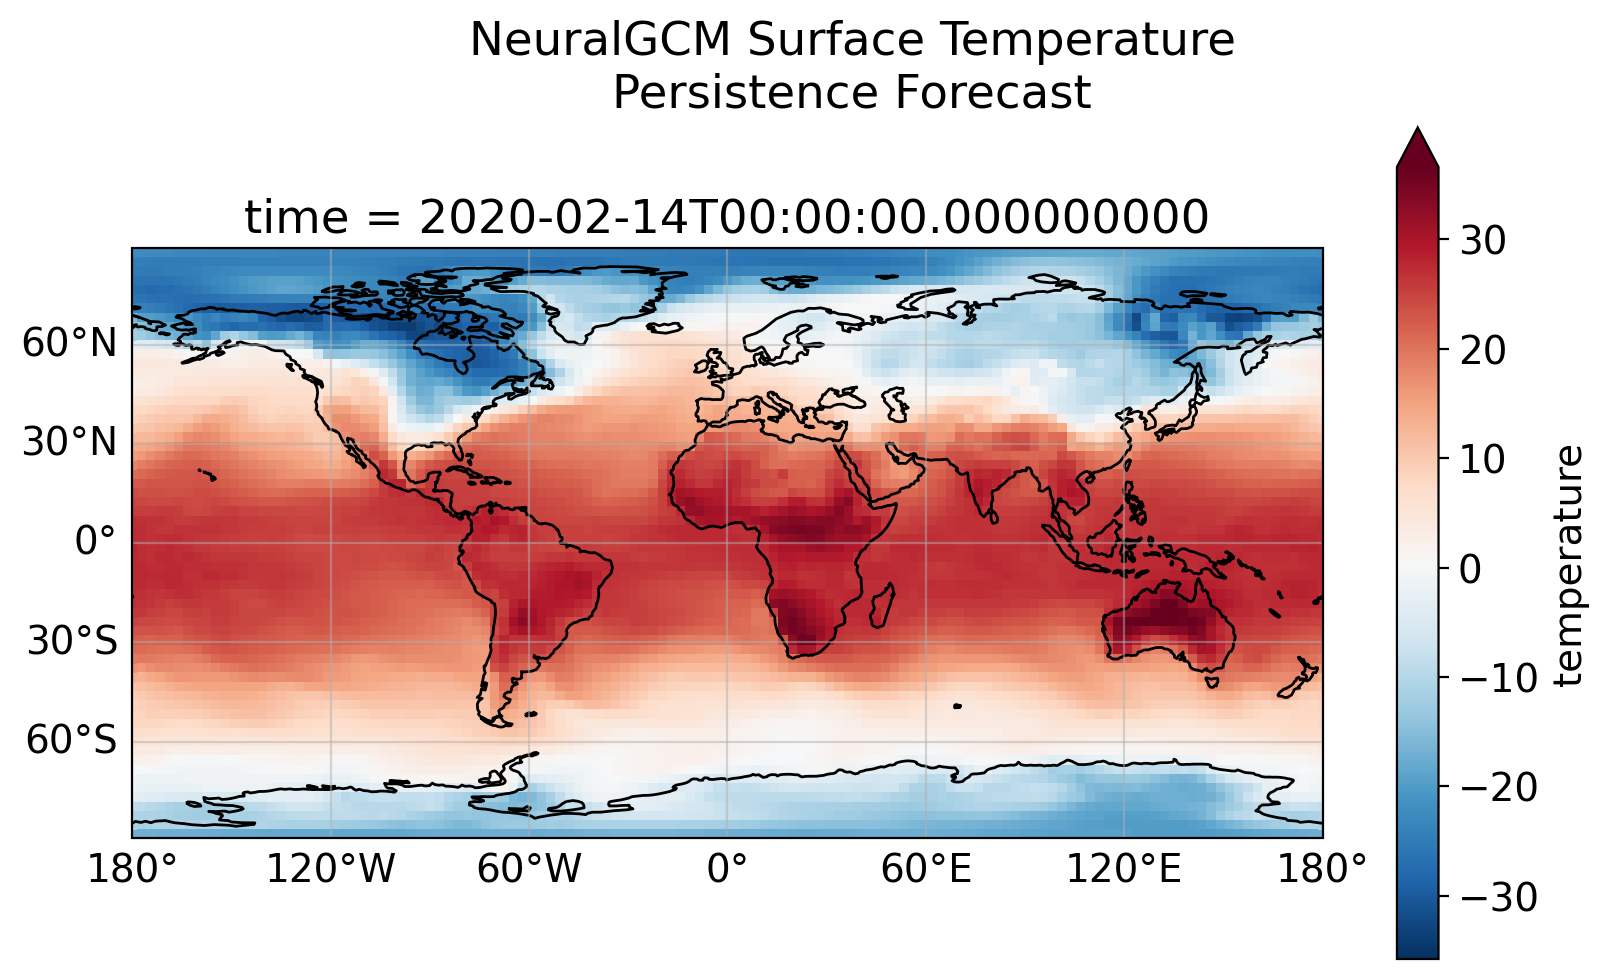

In [159]:
def custom_plotfunc(ds, fig, tt, *args, **kwargs):
    # Define station location for timeseries
    time = surface_temperature.time[tt].values
    fig.suptitle("NeuralGCM Surface Temperature\nPersistence Forecast")

    ax = fig.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  alpha=0.5, linestyle='-')
    gl.top_labels = False
    gl.right_labels = False    
    
    ds.isel(time=tt).plot(ax=ax, vmin=vmin, vmax=vmax, 
                          cmap='RdBu_r', transform = ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f"time = {time}")
    
    return None, None
    # ^ This is not strictly necessary, but otherwise a warning will be raised.

mov_custom = Movie(surface_temperature, custom_plotfunc)
mov_custom.preview(0)

In [160]:
mov_custom.save('movie_gif_custom.gif', overwrite_existing = True)  # Use to save a gif

Movie created at movie_mp4_custom.mp4
GIF created at movie_gif_custom.gif
